In [29]:
from cobra import Reaction, Metabolite
from cobra.io import read_sbml_model
from cobra.io import write_sbml_model
from cameo.visualization.plotting.with_plotly import PlotlyPlotter
from cameo import phenotypic_phase_plane
plotter = PlotlyPlotter()

## Model with media LB with added violacein

In [48]:
model_LB_vio_fad=read_sbml_model('Models/model_VN_LB_vio-fad.xml')

In [65]:
print(model_LB_vio_fad.optimize().fluxes['Violacein'])

0.0


Oxygen and glucose boundaries set to default values (-10):
- Growth rate for V. natriegens [h^-1]: 2.84059702054389
- Max. violacein production [mmol gDW^-1 h^-1]: 3.3333333333333344
- Theoretical maximum yield [mmol_vio / mmol_glc]: 0.3333333333333334


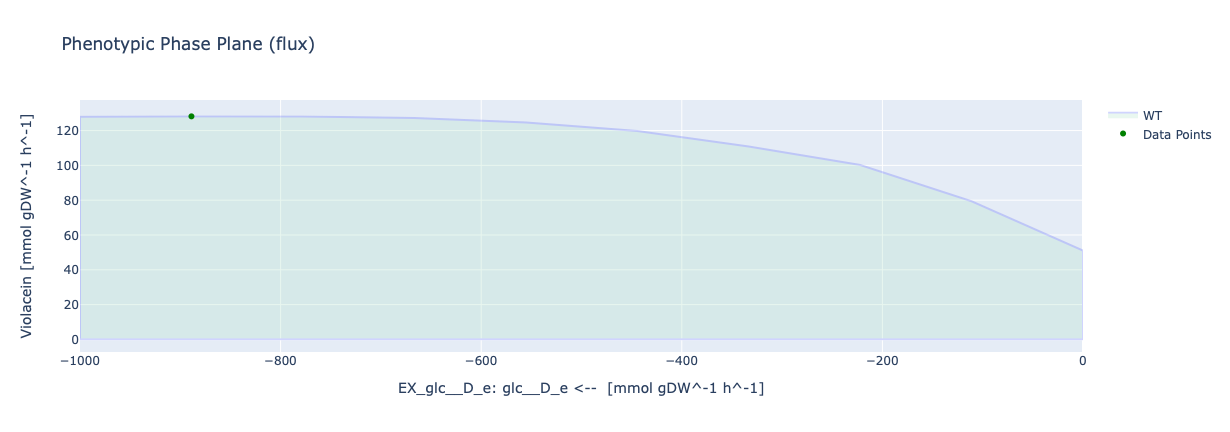

Setting o2 boundary to -1000, and glucose boundary to -1000:
- The optimal glucose uptake for Violacein flux is [h^-1]: -888.8888888888889
- Growth rate for V. natriegens [h^-1]: 38.691495129932335
- Max. violacein production [mmol gDW^-1 h^-1]: 128.16546762589928
- Theoretical maximum yield [mmol_vio / mmol_glc]: 0.16017562525287343


In [67]:
# With glucose as substrate
medium = model_LB_vio_fad.medium
with model_LB_vio_fad:
    
    model_LB_vio_fad.objective = model_LB_vio_fad.reactions.Growth
    growth_rate = model_LB_vio_fad.optimize().objective_value
    model_LB_vio_fad.objective = model_LB_vio_fad.reactions.Violacein
    violacein_production = model_LB_vio_fad.optimize().objective_value
    violacein_glc_yield = violacein_production / (-1*model_LB_vio_fad.reactions.EX_glc__D_e.flux)
    
    print('Oxygen and glucose boundaries set to default values (-10):')
    print('- Growth rate for V. natriegens [h^-1]:', growth_rate)
    print('- Max. violacein production [mmol gDW^-1 h^-1]:', violacein_production)
    print('- Theoretical maximum yield [mmol_vio / mmol_glc]:', violacein_glc_yield)
    
    model_LB_vio_fad.reactions.EX_o2_e.lower_bound = -1000
    model_LB_vio_fad.reactions.EX_glc__D_e.bounds = -1000,0
    model_LB_vio_fad.objective = model_LB_vio_fad.reactions.Growth
    growth_rate = model_LB_vio_fad.optimize().objective_value
    model_LB_vio_fad.objective = model_LB_vio_fad.reactions.Violacein
    violacein_production = model_LB_vio_fad.optimize().objective_value
    violacein_glc_yield = violacein_production / (-1*model_LB_vio_fad.reactions.EX_glc__D_e.flux)
    result = phenotypic_phase_plane(model_LB_vio_fad, 
                                variables=[model_LB_vio_fad.reactions.EX_glc__D_e],
                                objective=model_LB_vio_fad.reactions.Violacein,
                                points=10)
    x = result.data_frame.EX_glc__D_e[result.data_frame.objective_upper_bound.idxmax()]
    y = result.data_frame.objective_upper_bound[result.data_frame.objective_upper_bound.idxmax()]
    result.plot(plotter, points=[(x,y)], points_colors=["green"])
    
    print('Setting o2 boundary to -1000, and glucose boundary to -1000:')
    print("- The optimal glucose uptake for Violacein flux is [h^-1]:", result.data_frame.EX_glc__D_e[result.data_frame.objective_upper_bound.idxmax()])
    print('- Growth rate for V. natriegens [h^-1]:', growth_rate)
    print('- Max. violacein production [mmol gDW^-1 h^-1]:', violacein_production)
    print('- Theoretical maximum yield [mmol_vio / mmol_glc]:', violacein_glc_yield)

In [ ]:
# With glucose as substrate
medium = model_LB_vio_fad.medium
with model_LB_vio_fad:
    model_LB_vio_fad.objective = model_LB_vio_fad.reactions.Growth
    growth_rate = model_LB_vio_fad.optimize().objective_value
    model_LB_vio_fad.objective = model_LB_vio_fad.reactions.Violacein
    violacein_production = model_LB_vio_fad.optimize().objective_value
    violacein_glc_yield = violacein_production / (-1*model_LB_vio_fad.reactions.EX_glc__D_e.flux)
    
    print('Setting o2 boundary to -1000, and glucose boundary to -1000:')
    print('- Growth rate for V. natriegens [h^-1]:', growth_rate)
    print('- Max. violacein production [mmol gDW^-1 h^-1]:', violacein_production)
    print('- Theoretical maximum yield [mmol_vio / mmol_glc]:', violacein_glc_yield)

Growth rate for V. natriegens [h^-1]: 38.691495129932264
Max. violacein production [mmol gDW^-1 h^-1]: 120.71307300509343
Theoretical maximum yield [mmol_vio / mmol_mnl]: 0.17889792837373153


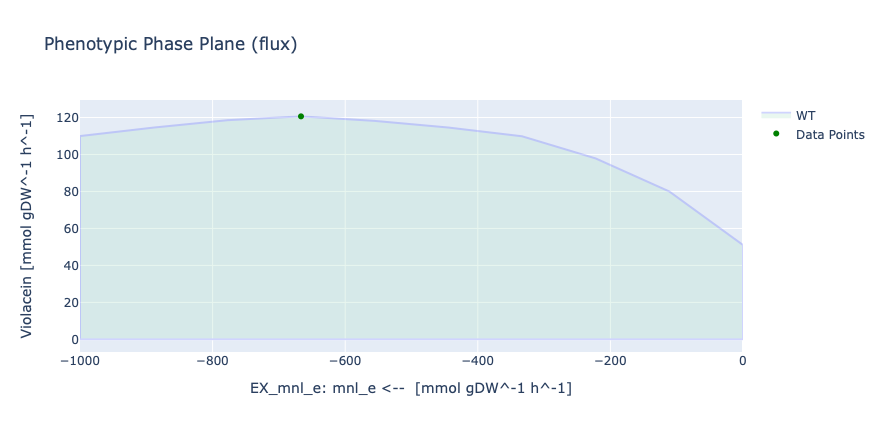

The optimal D-mannitol uptake for Violacein flux is: -666.6666666666666


In [33]:
# With D-mannitol as substrate
medium = model_LB_vio_fad.medium
with model_LB_vio_fad:
    medium['EX_glc__D_e'] = 0
    medium['EX_mnl_e'] = 1000
    model_LB_vio_fad.medium = medium
    model_LB_vio_fad.objective = model_LB_vio_fad.reactions.Growth
    growth_rate = model_LB_vio_fad.optimize().objective_value
    model_LB_vio_fad.objective = model_LB_vio_fad.reactions.Violacein
    violacein_production = model_LB_vio_fad.optimize().objective_value
    violacein_mnl_yield = violacein_production / (-1*model_LB_vio_fad.reactions.EX_mnl_e.flux)
    
    print('Growth rate for V. natriegens [h^-1]:', growth_rate)
    print('Max. violacein production [mmol gDW^-1 h^-1]:', violacein_production)
    print('Theoretical maximum yield [mmol_vio / mmol_mnl]:', violacein_mnl_yield)
    
    model_LB_vio_fad.reactions.EX_mnl_e.bounds = -1000,0
    result = phenotypic_phase_plane(model_LB_vio_fad, 
                                variables=[model_LB_vio_fad.reactions.EX_mnl_e],
                                objective=model_LB_vio_fad.reactions.Violacein,
                                points=10)
    x = result.data_frame.EX_mnl_e[result.data_frame.objective_upper_bound.idxmax()]
    y = result.data_frame.objective_upper_bound[result.data_frame.objective_upper_bound.idxmax()]
    result.plot(plotter, points=[(x,y)], points_colors=["green"])
    print("The optimal D-mannitol uptake for Violacein flux is:", result.data_frame.EX_mnl_e[result.data_frame.objective_upper_bound.idxmax()])

Growth rate for V. natriegens [h^-1]: 38.69149512993233
Max. violacein production [mmol gDW^-1 h^-1]: 139.76101335330088
Theoretical maximum yield [mmol_vio / mmol_sucr]: 0.3755600343398304


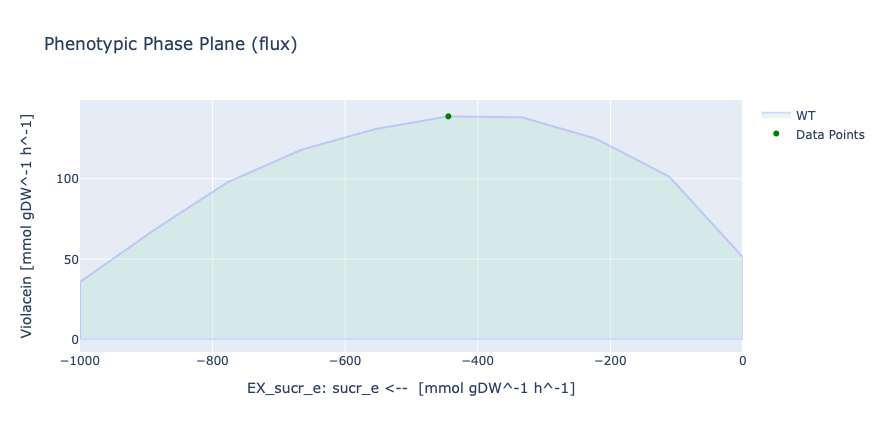

The optimal sucrose uptake for Violacein flux is: -444.44444444444446


In [34]:
# With sucrose as substrate
medium = model_LB_vio_fad.medium
with model_LB_vio_fad:
    medium['EX_glc__D_e'] = 0
    medium['EX_sucr_e'] = 1000
    model_LB_vio_fad.medium = medium
    model_LB_vio_fad.objective = model_LB_vio_fad.reactions.Growth
    growth_rate = model_LB_vio_fad.optimize().objective_value
    model_LB_vio_fad.objective = model_LB_vio_fad.reactions.Violacein
    violacein_production = model_LB_vio_fad.optimize().objective_value
    violacein_sucr_yield = violacein_production / (-1*model_LB_vio_fad.reactions.EX_sucr_e.flux)
    
    print('Growth rate for V. natriegens [h^-1]:', growth_rate)
    print('Max. violacein production [mmol gDW^-1 h^-1]:', violacein_production)
    print('Theoretical maximum yield [mmol_vio / mmol_sucr]:', violacein_sucr_yield)
    
    model_LB_vio_fad.reactions.EX_sucr_e.bounds = -1000,0
    result = phenotypic_phase_plane(model_LB_vio_fad, 
                                variables=[model_LB_vio_fad.reactions.EX_sucr_e],
                                objective=model_LB_vio_fad.reactions.Violacein,
                                points=10)
    x = result.data_frame.EX_sucr_e[result.data_frame.objective_upper_bound.idxmax()]
    y = result.data_frame.objective_upper_bound[result.data_frame.objective_upper_bound.idxmax()]
    result.plot(plotter, points=[(x,y)], points_colors=["green"])
    print("The optimal sucrose uptake for Violacein flux is:", result.data_frame.EX_sucr_e[result.data_frame.objective_upper_bound.idxmax()])

Growth rate for V. natriegens [h^-1]: 38.68348548338176
Max. violacein production [mmol gDW^-1 h^-1]: 107.30212445948555
Theoretical maximum yield [mmol_vio / mmol_glyc]: 0.10730212445948556


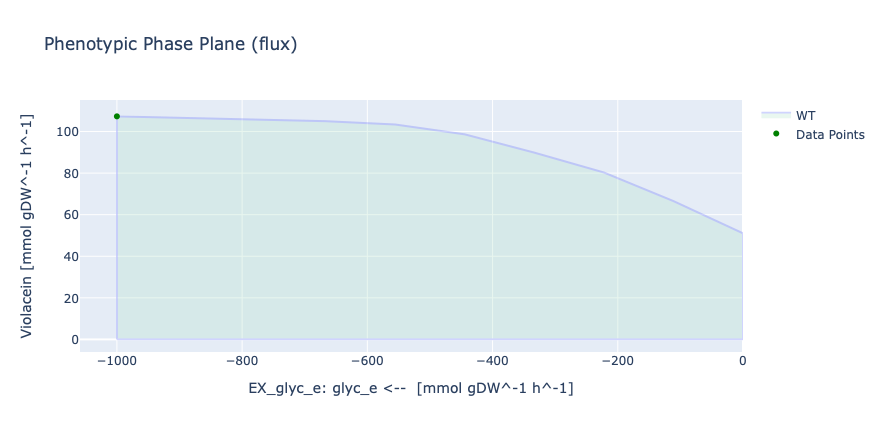

The optimal glycerol uptake for Violacein flux is: -1000.0


In [35]:
# With glycerol as substrate
medium = model_LB_vio_fad.medium
with model_LB_vio_fad:
    medium['EX_glc__D_e'] = 0
    medium['EX_glyc_e'] = 1000
    model_LB_vio_fad.medium = medium
    model_LB_vio_fad.objective = model_LB_vio_fad.reactions.Growth
    growth_rate = model_LB_vio_fad.optimize().objective_value
    model_LB_vio_fad.objective = model_LB_vio_fad.reactions.Violacein
    violacein_production = model_LB_vio_fad.optimize().objective_value
    violacein_glyc_yield = violacein_production / (-1*model_LB_vio_fad.reactions.EX_glyc_e.flux)
    
    print('Growth rate for V. natriegens [h^-1]:', growth_rate)
    print('Max. violacein production [mmol gDW^-1 h^-1]:', violacein_production)
    print('Theoretical maximum yield [mmol_vio / mmol_glyc]:', violacein_glyc_yield)
    
    model_LB_vio_fad.reactions.EX_glyc_e.bounds = -1000,0
    result = phenotypic_phase_plane(model_LB_vio_fad, 
                                variables=[model_LB_vio_fad.reactions.EX_glyc_e],
                                objective=model_LB_vio_fad.reactions.Violacein,
                                points=10)
    x = result.data_frame.EX_glyc_e[result.data_frame.objective_upper_bound.idxmax()]
    y = result.data_frame.objective_upper_bound[result.data_frame.objective_upper_bound.idxmax()]
    result.plot(plotter, points=[(x,y)], points_colors=["green"])
    print("The optimal glycerol uptake for Violacein flux is:", result.data_frame.EX_glyc_e[result.data_frame.objective_upper_bound.idxmax()])

Growth rate for V. natriegens [h^-1]: 31.595728343094624
Max. violacein production [mmol gDW^-1 h^-1]: 130.52631578947359
Theoretical maximum yield [mmol_vio / mmol_acgam]: 0.18797372410308222


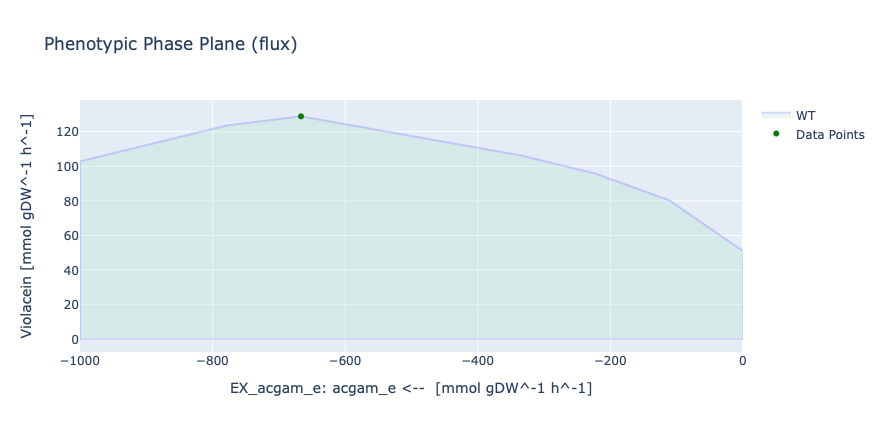

The optimal N-acetyl-D-glucosamine uptake for Violacein flux is: -666.6666666666666


In [36]:
# With N-acetyl-D-glucosamine as substrate
medium = model_LB_vio_fad.medium
with model_LB_vio_fad:
    medium['EX_glc__D_e'] = 0
    medium['EX_acgam_e'] = 1000
    model_LB_vio_fad.medium = medium
    model_LB_vio_fad.objective = model_LB_vio_fad.reactions.Growth
    growth_rate = model_LB_vio_fad.optimize().objective_value
    model_LB_vio_fad.objective = model_LB_vio_fad.reactions.Violacein
    violacein_production = model_LB_vio_fad.optimize().objective_value
    violacein_acgam_yield = violacein_production / (-1*model_LB_vio_fad.reactions.EX_acgam_e.flux)
    
    print('Growth rate for V. natriegens [h^-1]:', growth_rate)
    print('Max. violacein production [mmol gDW^-1 h^-1]:', violacein_production)
    print('Theoretical maximum yield [mmol_vio / mmol_acgam]:', violacein_acgam_yield)
    
    model_LB_vio_fad.reactions.EX_acgam_e.bounds = -1000,0
    result = phenotypic_phase_plane(model_LB_vio_fad, 
                                variables=[model_LB_vio_fad.reactions.EX_acgam_e],
                                objective=model_LB_vio_fad.reactions.Violacein,
                                points=10)
    x = result.data_frame.EX_acgam_e[result.data_frame.objective_upper_bound.idxmax()]
    y = result.data_frame.objective_upper_bound[result.data_frame.objective_upper_bound.idxmax()]
    result.plot(plotter, points=[(x,y)], points_colors=["green"])
    print("The optimal N-acetyl-D-glucosamine uptake for Violacein flux is:", result.data_frame.EX_acgam_e[result.data_frame.objective_upper_bound.idxmax()])

## Model with media M9 with added violacein

In [37]:
model_M9_vio_fad=read_sbml_model('Models/model_VN_M9_vio-fad.xml')

Set aerobic conditions:

In [38]:
model_M9_vio_fad.reactions.EX_o2_e.lower_bound = -100

Growth rate for V. natriegens [h^-1]: 0.8930785785011194
Max. violacein production [mmol gDW^-1 h^-1]: 2.365364308342132
Theoretical maximum yield [mmol_vio / mmol_glc]: 0.2365364308342132


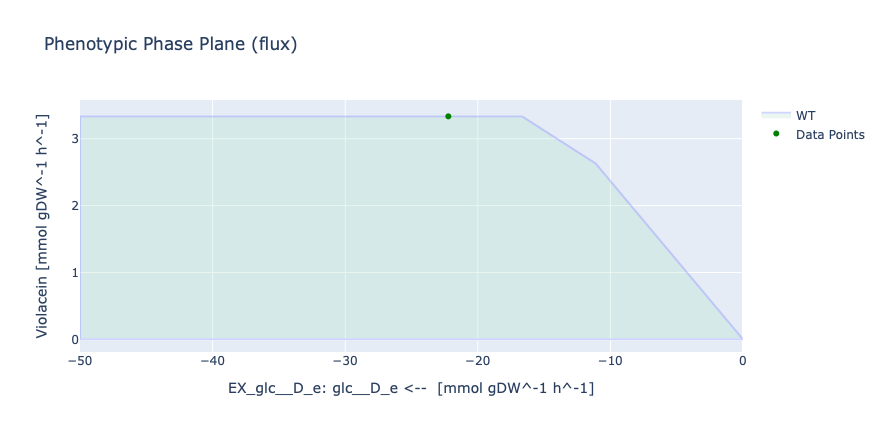

The optimal glucose uptake for Violacein flux is: -22.22222222222222


In [39]:
# With glucose as substrate
medium = model_M9_vio_fad.medium
with model_M9_vio_fad:
    model_M9_vio_fad.objective = model_M9_vio_fad.reactions.Growth
    growth_rate = model_M9_vio_fad.optimize().objective_value
    model_M9_vio_fad.objective = model_M9_vio_fad.reactions.Violacein
    violacein_production = model_M9_vio_fad.optimize().objective_value
    violacein_glc_yield = violacein_production / (-1*model_M9_vio_fad.reactions.EX_glc__D_e.flux)
    
    print('Growth rate for V. natriegens [h^-1]:', growth_rate)
    print('Max. violacein production [mmol gDW^-1 h^-1]:', violacein_production)
    print('Theoretical maximum yield [mmol_vio / mmol_glc]:', violacein_glc_yield)
    
    model_M9_vio_fad.reactions.EX_glc__D_e.bounds = -50,0
    result = phenotypic_phase_plane(model_M9_vio_fad, 
                                variables=[model_M9_vio_fad.reactions.EX_glc__D_e],
                                objective=model_M9_vio_fad.reactions.Violacein,
                                points=10)
    x = result.data_frame.EX_glc__D_e[result.data_frame.objective_upper_bound.idxmax()]
    y = result.data_frame.objective_upper_bound[result.data_frame.objective_upper_bound.idxmax()]
    result.plot(plotter, points=[(x,y)], points_colors=["green"])
    print("The optimal glucose uptake for Violacein flux is:", result.data_frame.EX_glc__D_e[result.data_frame.objective_upper_bound.idxmax()])

Growth rate for V. natriegens [h^-1]: 0.893078578501115
Max. violacein production [mmol gDW^-1 h^-1]: 2.433234421364988
Theoretical maximum yield [mmol_vio / mmol_mnl]: 0.24332344213649879


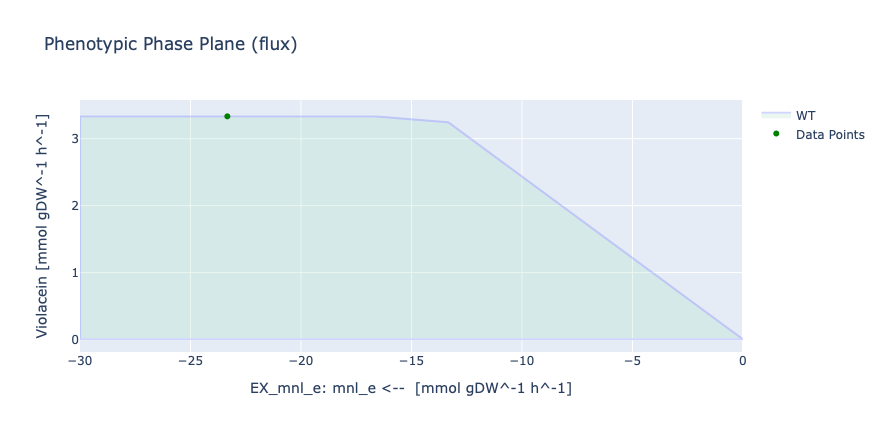

The optimal glucose uptake for Violacein flux is: -23.333333333333332


In [40]:
# With D-mannitol as substrate
medium = model_M9_vio_fad.medium
with model_M9_vio_fad:
    medium['EX_glc__D_e'] = 0
    medium['EX_mnl_e'] = 10
    model_M9_vio_fad.medium = medium
    model_M9_vio_fad.objective = model_M9_vio_fad.reactions.Growth
    growth_rate = model_M9_vio_fad.optimize().objective_value
    model_M9_vio_fad.objective = model_M9_vio_fad.reactions.Violacein
    violacein_production = model_M9_vio_fad.optimize().objective_value
    violacein_mnl_yield = violacein_production / (-1*model_M9_vio_fad.reactions.EX_mnl_e.flux)
    
    print('Growth rate for V. natriegens [h^-1]:', growth_rate)
    print('Max. violacein production [mmol gDW^-1 h^-1]:', violacein_production)
    print('Theoretical maximum yield [mmol_vio / mmol_mnl]:', violacein_mnl_yield)
    
    model_M9_vio_fad.reactions.EX_mnl_e.bounds = -30,0
    result = phenotypic_phase_plane(model_M9_vio_fad, 
                                variables=[model_M9_vio_fad.reactions.EX_mnl_e],
                                objective=model_M9_vio_fad.reactions.Violacein,
                                points=10)
    x = result.data_frame.EX_mnl_e[result.data_frame.objective_upper_bound.idxmax()]
    y = result.data_frame.objective_upper_bound[result.data_frame.objective_upper_bound.idxmax()]
    result.plot(plotter, points=[(x,y)], points_colors=["green"])
    print("The optimal glucose uptake for Violacein flux is:", result.data_frame.EX_mnl_e[result.data_frame.objective_upper_bound.idxmax()])

Growth rate for V. natriegens [h^-1]: 0.8930785785011193
Max. violacein production [mmol gDW^-1 h^-1]: 3.3333333333333326
Theoretical maximum yield [mmol_vio / mmol_sucr]: 0.3965517241379309


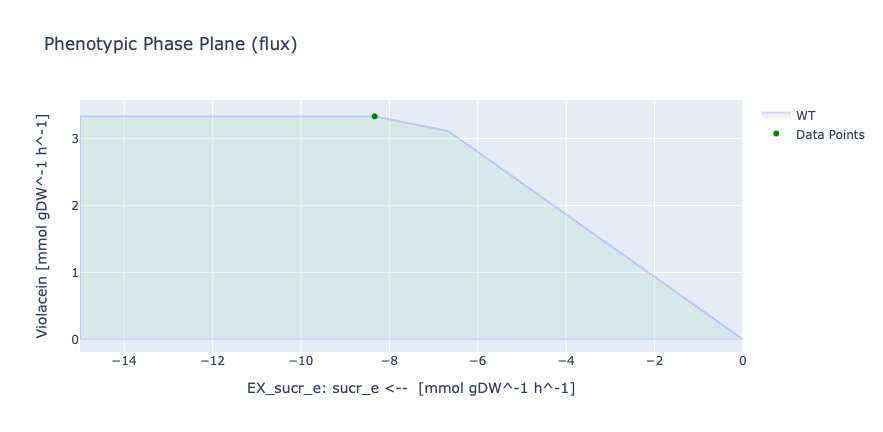

The optimal sucrose uptake for Violacein flux is: -8.333333333333332


In [41]:
# With sucrose as substrate
medium = model_M9_vio_fad.medium
with model_M9_vio_fad:
    medium['EX_glc__D_e'] = 0
    medium['EX_sucr_e'] = 10
    model_M9_vio_fad.medium = medium
    model_M9_vio_fad.objective = model_M9_vio_fad.reactions.Growth
    growth_rate = model_M9_vio_fad.optimize().objective_value
    model_M9_vio_fad.objective = model_M9_vio_fad.reactions.Violacein
    violacein_production = model_M9_vio_fad.optimize().objective_value
    violacein_sucr_yield = violacein_production / (-1*model_M9_vio_fad.reactions.EX_sucr_e.flux)
    
    print('Growth rate for V. natriegens [h^-1]:', growth_rate)
    print('Max. violacein production [mmol gDW^-1 h^-1]:', violacein_production)
    print('Theoretical maximum yield [mmol_vio / mmol_sucr]:', violacein_sucr_yield)
    
    model_M9_vio_fad.reactions.EX_sucr_e.bounds = -15,0
    result = phenotypic_phase_plane(model_M9_vio_fad, 
                                variables=[model_M9_vio_fad.reactions.EX_sucr_e],
                                objective=model_M9_vio_fad.reactions.Violacein,
                                points=10)
    x = result.data_frame.EX_sucr_e[result.data_frame.objective_upper_bound.idxmax()]
    y = result.data_frame.objective_upper_bound[result.data_frame.objective_upper_bound.idxmax()]
    result.plot(plotter, points=[(x,y)], points_colors=["green"])
    print("The optimal sucrose uptake for Violacein flux is:", result.data_frame.EX_sucr_e[result.data_frame.objective_upper_bound.idxmax()])

Growth rate for V. natriegens [h^-1]: 0.5623531490066539
Max. violacein production [mmol gDW^-1 h^-1]: 1.2816188870151766
Theoretical maximum yield [mmol_vio / mmol_glyc]: 0.12816188870151765


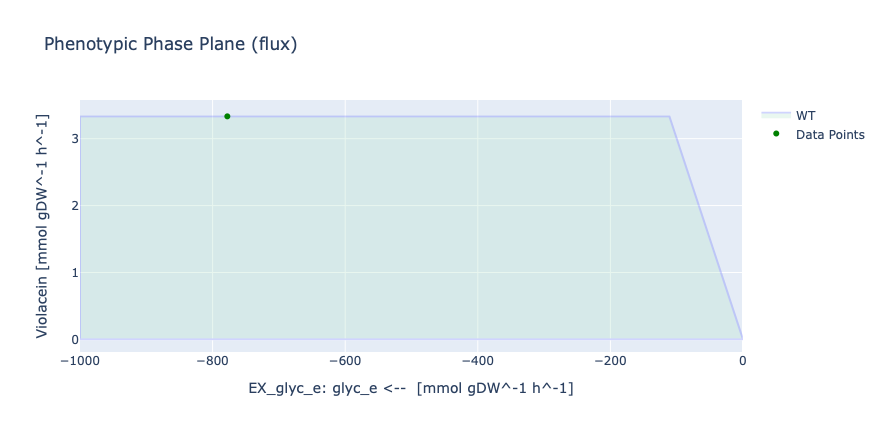

The optimal glycerol uptake for Violacein flux is: -777.7777777777777


In [42]:
# With glycerol as substrate
medium = model_M9_vio_fad.medium
with model_M9_vio_fad:
    medium['EX_glc__D_e'] = 0
    medium['EX_glyc_e'] = 10
    model_M9_vio_fad.medium = medium
    model_M9_vio_fad.objective = model_M9_vio_fad.reactions.Growth
    growth_rate = model_M9_vio_fad.optimize().objective_value
    model_M9_vio_fad.objective = model_M9_vio_fad.reactions.Violacein
    violacein_production = model_M9_vio_fad.optimize().objective_value
    violacein_glyc_yield = violacein_production / (-1*model_M9_vio_fad.reactions.EX_glyc_e.flux)
    
    print('Growth rate for V. natriegens [h^-1]:', growth_rate)
    print('Max. violacein production [mmol gDW^-1 h^-1]:', violacein_production)
    print('Theoretical maximum yield [mmol_vio / mmol_glyc]:', violacein_glyc_yield)
    
    model_M9_vio_fad.reactions.EX_glyc_e.bounds = -1000,0
    result = phenotypic_phase_plane(model_M9_vio_fad, 
                                variables=[model_M9_vio_fad.reactions.EX_glyc_e],
                                objective=model_M9_vio_fad.reactions.Violacein,
                                points=10)
    x = result.data_frame.EX_glyc_e[result.data_frame.objective_upper_bound.idxmax()]
    y = result.data_frame.objective_upper_bound[result.data_frame.objective_upper_bound.idxmax()]
    result.plot(plotter, points=[(x,y)], points_colors=["green"])
    print("The optimal glycerol uptake for Violacein flux is:", result.data_frame.EX_glyc_e[result.data_frame.objective_upper_bound.idxmax()])

Growth rate for V. natriegens [h^-1]: 1.2889277191657496
Max. violacein production [mmol gDW^-1 h^-1]: 2.926406926406931
Theoretical maximum yield [mmol_vio / mmol_acgam]: 0.2926406926406931


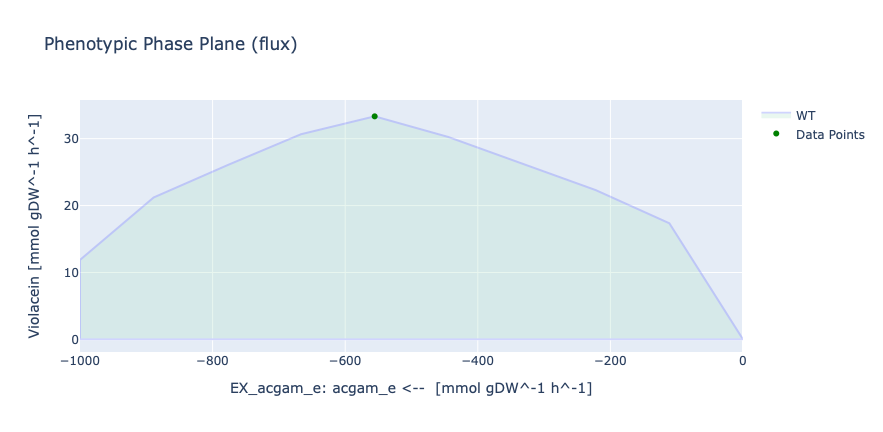

The optimal N-acetyl-D-glucosamine uptake for Violacein flux is: -555.5555555555554


In [43]:
# With N-acetyl-D-glucosamine as substrate
medium = model_M9_vio_fad.medium
with model_M9_vio_fad:
    medium['EX_glc__D_e'] = 0
    medium['EX_acgam_e'] = 10
    model_M9_vio_fad.medium = medium
    model_M9_vio_fad.objective = model_M9_vio_fad.reactions.Growth
    growth_rate = model_M9_vio_fad.optimize().objective_value
    model_M9_vio_fad.objective = model_M9_vio_fad.reactions.Violacein
    violacein_production = model_M9_vio_fad.optimize().objective_value
    violacein_acgam_yield = violacein_production / (-1*model_M9_vio_fad.reactions.EX_acgam_e.flux)
    
    print('Growth rate for V. natriegens [h^-1]:', growth_rate)
    print('Max. violacein production [mmol gDW^-1 h^-1]:', violacein_production)
    print('Theoretical maximum yield [mmol_vio / mmol_acgam]:', violacein_acgam_yield)
    
    model_M9_vio_fad.reactions.EX_acgam_e.bounds = -1000,0
    result = phenotypic_phase_plane(model_M9_vio_fad, 
                                variables=[model_M9_vio_fad.reactions.EX_acgam_e],
                                objective=model_M9_vio_fad.reactions.Violacein,
                                points=10)
    x = result.data_frame.EX_acgam_e[result.data_frame.objective_upper_bound.idxmax()]
    y = result.data_frame.objective_upper_bound[result.data_frame.objective_upper_bound.idxmax()]
    result.plot(plotter, points=[(x,y)], points_colors=["green"])
    print("The optimal N-acetyl-D-glucosamine uptake for Violacein flux is:", result.data_frame.EX_acgam_e[result.data_frame.objective_upper_bound.idxmax()])